In [6]:
# Imported Libraries
# References:Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn by Coding-Maniac
# Credit Fraud dealing with imbalanced data - Kaggle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from sklearn.metrics import (confusion_matrix, roc_curve, classification_report, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score)
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#To know the distribution of the classes
print('Legit transactions', round(data['Class'].value_counts()[0]/len(data) * 100,2))
print('Fraudulent transactions', round(data['Class'].value_counts()[1]/len(data) * 100,2))

Legit transactions 99.83
Fraudulent transactions 0.17


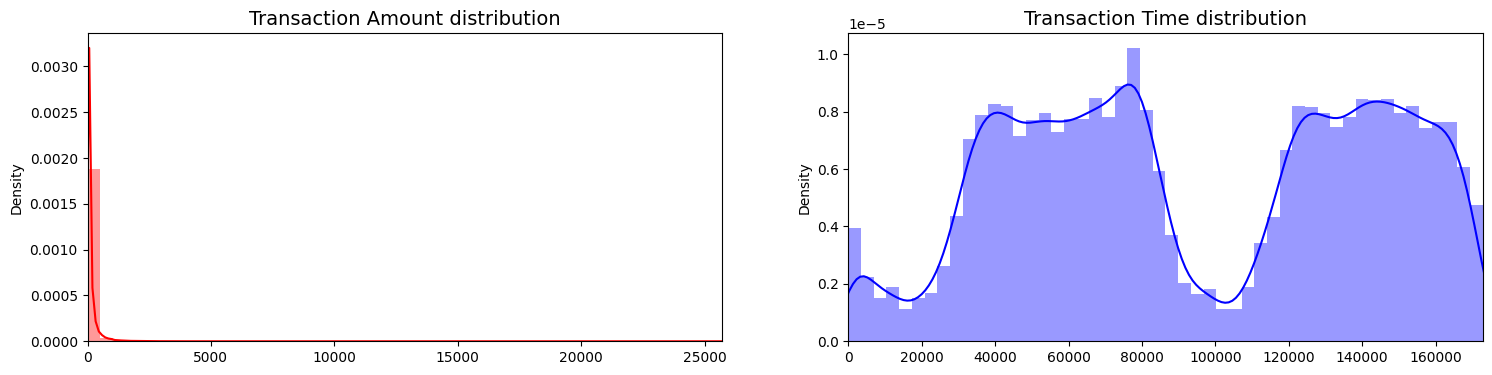

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data['Amount'].values
time_val = data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Transaction Amount distribution', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Transaction Time distribution', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [7]:
#Generate new data to address the data imbalance issue
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['normalized_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['normalized_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)

normalized_amount = data['normalized_amount']
normalized_time = data['normalized_time']

data.drop(['normalized_amount', 'normalized_time'], axis=1, inplace=True)
data.insert(0, 'normalized_amount', normalized_amount)
data.insert(1, 'normalized_time', normalized_time)

# Amount and Time are Scaled!

data.head()

,normalized_amount,normalized_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X = data.drop('Class', axis=1)
y = data['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [ ]:
#Random sampling
data = data.sample(frac=1)


fraud_df = data.loc[df['Class'] == 1]
non_fraud_df = data.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])


new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,normalized_amount,normalized_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
114456,-0.289387,-0.131592,1.320746,0.276806,0.176258,0.417462,-0.013427,-0.498079,0.087659,-0.188894,...,-0.025325,-0.305340,-0.845033,0.025495,-0.442486,0.351558,0.144433,-0.025794,0.011834,0
199896,18.346957,0.569697,-1.212682,-2.484824,-6.397186,3.670562,-0.863375,-1.855855,1.017732,-0.544704,...,2.908374,1.396872,0.092073,-1.492882,-0.204227,0.532511,-0.293871,0.212663,0.431095,1
170488,0.656746,0.417192,2.019720,-1.365614,-0.537747,-0.940965,-1.310911,-0.286467,-1.265447,0.149703,...,-0.014905,0.446180,1.090172,0.061994,-0.407358,-0.290254,-0.059725,-0.008284,-0.052732,0
249828,-0.213233,0.821285,0.667714,3.041502,-5.845112,5.967587,0.213863,-1.462923,-2.688761,0.677764,...,0.558425,0.329760,-0.941383,-0.006075,-0.958925,0.239298,-0.067356,0.821048,0.426175,1
15476,1.089779,-0.679390,-21.209120,12.652197,-23.553933,6.174078,-16.026658,-4.422195,-16.229444,14.116002,...,1.602439,1.758440,-1.522588,-0.903860,0.130166,1.454857,-0.223214,1.550928,0.461460,1


In [ ]:
#Dimensionality reduction techniques
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()

# PCA
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()

# SVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()

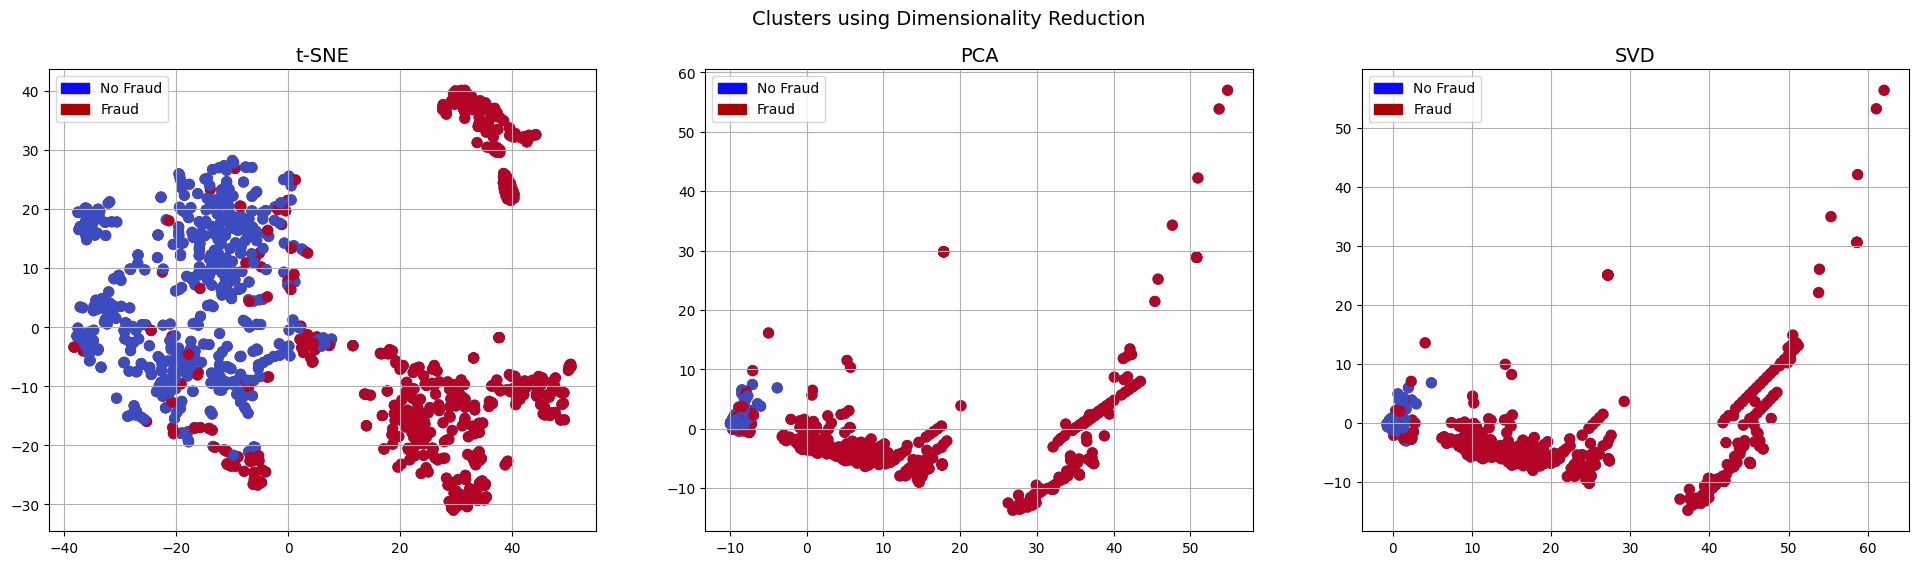

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [ ]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values


classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression 94.0 % accuracy score
Classifiers:  KNeighborsClassifier 94.0 % accuracy score
Classifiers:  SVC 94.0 % accuracy score
Classifiers:  DecisionTreeClassifier 89.0 % accuracy score


In [ ]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

# **Anomaly Detection using Isolation Forest Tree Model**

In [8]:
#Creating a subsample with equal distribution of both the classes
data = data.sample(frac=1)
fraud_df =  data[data['Class'] ==1]
non_fraud_df = data.loc[np.random.choice(data.index, 492, replace=False)]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df],axis=0)
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df = pd.DataFrame(new_df)
new_df.head()

,normalized_amount,normalized_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
221040,1.330818,0.678062,-1.273105,0.054911,1.550412,2.458985,0.881440,3.520684,0.208709,0.275913,...,-0.705828,0.161249,1.225386,0.365823,-0.977038,-0.820438,-0.114432,-0.928642,-0.190979,0
150692,0.222595,0.108225,-11.320633,7.191950,-13.179083,9.099552,-10.094749,-2.440115,-14.184337,4.452503,...,-0.180935,1.082235,-0.350563,0.483044,0.661133,-0.396522,-0.413315,-0.997548,-0.235036,1
193730,0.306016,0.535439,2.122708,-0.837441,-1.207116,-0.775841,-0.201743,0.134036,-0.562581,-0.035908,...,-0.449290,-0.864634,-2.043560,0.399044,-1.456099,-0.639199,0.103567,-0.043304,-0.059882,0
96994,-0.202194,-0.219164,0.286302,1.399345,-1.682503,3.864377,-1.185373,-0.341732,-2.539380,0.768378,...,0.270360,0.352456,-0.243678,-0.194079,-0.172201,0.742237,0.127790,0.569731,0.291206,1
189878,-0.293440,0.515784,-5.313774,2.664274,-4.250707,0.394707,-0.391383,0.683526,-5.133671,-7.907790,...,-2.642902,8.664662,-2.716383,0.483559,0.079235,0.311065,0.555544,0.176740,0.362907,1


In [9]:
X = data.drop(['Class'], axis=1)
y = data['Class']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state = 42 )

The errors of the Isolation Forest model is  711 

Model Accuracy: 1.0
Model Precision: 0.37
Model Recall: 0.31
Model F1-Score: 0.34
Model ROC: 0.66 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284226
           1       0.37      0.31      0.34       581

    accuracy                           1.00    284807
   macro avg       0.68      0.66      0.67    284807
weighted avg       1.00      1.00      1.00    284807
 



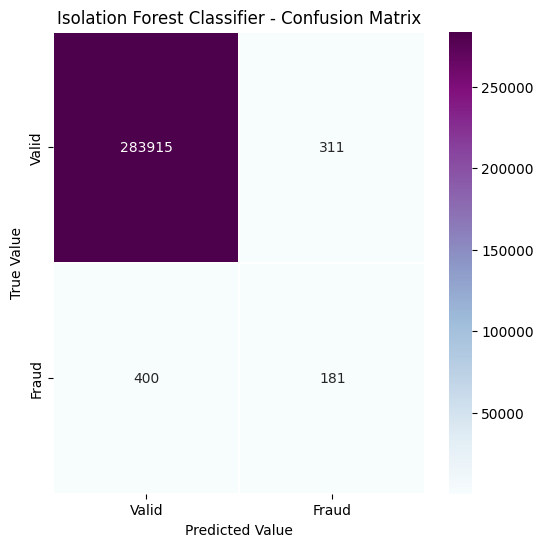

In [11]:
# ISOLATION FOREST TREE MODEL

from sklearn.ensemble import IsolationForest

isf = IsolationForest(random_state = 42, max_samples = len(X)).fit(X)
y_prediction = isf.predict(X)


y_prediction[y_prediction ==  1] = 0
y_prediction[y_prediction == -1] = 1

errors = (y_prediction != y).sum()

print("Accuracy:", round(accuracy_score(y_prediction , y),2))
print("Precision:", round(precision_score(y_prediction , y),2))
print("Recall:", round(recall_score(y_prediction , y),2))
print("F1-Score:", round(f1_score(y_prediction , y),2))
print("ROC:", round(roc_auc_score(y_prediction , y),2) , '\n')


conf_matrix=confusion_matrix(y_prediction,y)
labels= ['Non-fraud', 'Fraud']
plt.figure(figsize=(6, 6))

sns.heatmap(pd.DataFrame(conf_matrix), xticklabels= labels, yticklabels= labels,
            linewidths= 0.05 ,annot=True, fmt="d" , cmap='BuPu')

print(classification_report(y_prediction , y) , '\n')

plt.title("Isolation Forest Classifier - Confusion Matrix")
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
plt.show()